# prepare

In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Geod
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Data Clean

In [18]:
def cutomizedCoordinationFix(df):
    df = df.assign(rev=df.dropoff_latitude<df.dropoff_longitude)
    idx = (df['rev'] == 1)
    df.loc[idx,['dropoff_longitude','dropoff_latitude']] = df.loc[idx,['dropoff_latitude','dropoff_longitude']].values
    df.loc[idx,['pickup_longitude','pickup_latitude']] = df.loc[idx,['pickup_latitude','pickup_longitude']].values
    df = df.drop(columns=['rev'])
    return df

def clean_df(df):    
    #reverse incorrectly assigned longitude/latitude values
    df = cutomizedCoordinationFix(df)
    df = df[(df.fare_amount > 0)  & (df.fare_amount <= 500) &
          (df.passenger_count >= 0) & (df.passenger_count <= 8)  &
           ((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0) )]
    
    return df

# Use Featuretools to create feature

In [29]:
import featuretools as ft
print(f"featuretools version is {ft.__version__}")

from featuretools.primitives import TransformPrimitive
from woodwork.column_schema import ColumnSchema
from woodwork.logical_types import Double, LatLong, Datetime, Boolean

class GeoBox(TransformPrimitive):
    name = "GeoBox"
    input_types=[ColumnSchema(logical_type=LatLong)]
    return_type=ColumnSchema(logical_type=Boolean)
    
    def __init__(self, bottomleft, topright):
        self.bottomleft = bottomleft
        self.topright = topright
    
    def get_function(self):
        def geobox(latlong, bottomleft=self.bottomleft, topright=self.topright):
            lat = np.array([x[0] for x in latlong])
            lon = np.array([x[1] for x in latlong])
            boxlats = [bottomleft[0],topright[0]]
            boxlongs = [bottomleft[1], topright[1]]
            output = []
            for i, name in enumerate(lat):
                if (min(boxlats) <= lat[i] and lat[i] <= max(boxlats) and 
                        min(boxlongs) <= lon[i] and lon[i] <= max(boxlongs)):
                    output.append(True)
                else: 
                    output.append(False)
            return output
        
        return geobox

    def generate_name(self, base_feature_names):
        return u"GEOBOX({}, {}, {})".format(base_feature_names[0],
                                            str(self.bottomleft),
                                            str(self.topright))

class RushHour(TransformPrimitive):
    name = "is_rush_hour"
    input_types=[ColumnSchema(logical_type=Datetime)]
    return_type = ColumnSchema(logical_type=Boolean)
    def get_function(self):
        def is_rush_hour(datetime):
            hour = pd.DatetimeIndex(datetime).hour
            return (hour >= 7) & (hour <= 11)
        return is_rush_hour
    
class NoonHour(TransformPrimitive):
    name = "is_noon_hour"
    input_types=[ColumnSchema(logical_type=Datetime)]
    return_type = ColumnSchema(logical_type=Boolean)
    def get_function(self):
        def is_noon_hour(datetime):
            hour = pd.DatetimeIndex(datetime).hour
            return (hour >= 11) & (hour <= 13)
        return is_noon_hour

class NightHour(TransformPrimitive):
    name = "is_night_hour"
    input_types=[ColumnSchema(logical_type=Datetime)]
    return_type = ColumnSchema(logical_type=Boolean)
    def get_function(self):
        def is_night_hour(datetime):
            hour = pd.DatetimeIndex(datetime).hour
            return (hour >= 18) & (hour <= 23)
        return is_night_hour

def haversine(latlong1, latlong2):
    lat_1s = np.array([x[0] for x in latlong1])
    lon_1s = np.array([x[1] for x in latlong1])
    lat_2s = np.array([x[0] for x in latlong2])
    lon_2s = np.array([x[1] for x in latlong2])
    lon1, lat1, lon2, lat2 = map(np.radians, [lon_1s, lat_1s, lon_2s, lat_2s])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    km = 6367 * 2 * np.arcsin(np.sqrt(a))
    return km

class Cityblock(TransformPrimitive):
    name = "cityblock"
    input_types = [ColumnSchema(logical_type=LatLong), ColumnSchema(logical_type=LatLong)]
    return_type = ColumnSchema(logical_type=Double, semantic_tags={'numeric'})
    number_output_features = 1
    commutative=True
    def get_function(self):
        def cityblock(latlong1, latlong2):
            lon_dis = haversine(latlong1, latlong2)
            lat_dist = haversine(latlong1, latlong2)
            return lon_dis + lat_dist
        return cityblock
    
class Bearing(TransformPrimitive):
    name = "bearing"
    input_types = [ColumnSchema(logical_type=LatLong), ColumnSchema(logical_type=LatLong)]
    return_type = ColumnSchema(logical_type=Double, semantic_tags={'numeric'})
    number_output_features = 1
    commutative=True
    def get_function(self):
        def bearing(latlong1, latlong2):
            lat1 = np.array([x[0] for x in latlong1])
            lon1 = np.array([x[1] for x in latlong1])
            lat2 = np.array([x[0] for x in latlong2])
            lon2 = np.array([x[1] for x in latlong2])
            delta_lon = np.radians(lon2 - lon1)
            lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
            x = np.cos(lat2) * np.sin(delta_lon)
            y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon)
            return np.degrees(np.arctan2(x, y))
        return bearing


featuretools version is 1.18.0


# featuretools related function

In [34]:
from woodwork.logical_types import Ordinal

def produce_featuretools_entityset(es, df):
    trip_logical_types = {
        'passenger_count': Ordinal(order=list(range(0, 10))), 
        'pickup_latlong': 'LatLong',
        'dropoff_latlong': 'LatLong',
    }

    es.add_dataframe(dataframe_name="trips",
                     dataframe=df,
                     index="id",
                     time_index='pickup_datetime',
                     logical_types=trip_logical_types)

    es.normalize_dataframe(base_dataframe_name="trips",
                           new_dataframe_name="passenger_cnt",
                           index="passenger_count")
    return es


In [35]:
def get_coordination(df):
    df["pickup_latlong"] = df[['pickup_latitude', 'pickup_longitude']].apply(tuple, axis=1)
    df["dropoff_latlong"] = df[['dropoff_latitude', 'dropoff_longitude']].apply(tuple, axis=1)
    df = df.drop(["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"], axis = 1)
    return df

def modelling_features(df):
    df = get_coordination(df)
    print(df.dtypes)

    es = ft.EntitySet("nyc_taxi_fare")
    es = produce_featuretools_entityset(es, df)
    
    cutoff_time = es['trips'][['id', 'pickup_datetime']]
    
    agg_primitives = []
    trans_primitives = [Bearing, Cityblock,
                        GeoBox(bottomleft=(40.62, -73.85), topright=(40.70, -73.75)),
                        GeoBox(bottomleft=(40.70, -73.97), topright=(40.77, -73.9)),
                        RushHour,
                        NoonHour,
                        NightHour]

    # calculate feature_matrix using deep feature synthesis
    df, features = ft.dfs(entityset=es,
                      target_dataframe_name="trips",
                      trans_primitives=trans_primitives,
                      agg_primitives=agg_primitives,
                      drop_contains=['trips.test_data'],
                      verbose=True,
                      cutoff_time=cutoff_time,
                      approximate='36d',
                      max_depth=3,
                      max_features=40)
    
    return df, es, features

In [32]:
train, es, features = modelling_features(train)
es.plot()
display(train)

fare_amount        float64
pickup_datetime     object
passenger_count      int64
pickup_latlong      object
dropoff_latlong     object
dtype: object
Built 14 features
Elapsed: 00:17 | Progress: 100%|██████████


,fare_amount,passenger_count,"GEOBOX(dropoff_latlong, (40.62, -73.85), (40.7, -73.75))","GEOBOX(pickup_latlong, (40.62, -73.85), (40.7, -73.75))","GEOBOX(dropoff_latlong, (40.7, -73.97), (40.77, -73.9))","GEOBOX(pickup_latlong, (40.7, -73.97), (40.77, -73.9))","BEARING(dropoff_latlong, pickup_latlong)","CITYBLOCK(dropoff_latlong, pickup_latlong)",IS_NIGHT_HOUR(pickup_datetime),IS_NOON_HOUR(pickup_datetime),IS_RUSH_HOUR(pickup_datetime),passenger_cnt.IS_NIGHT_HOUR(first_trips_time),passenger_cnt.IS_NOON_HOUR(first_trips_time),passenger_cnt.IS_RUSH_HOUR(first_trips_time)
id,,,,,,,,,,,,,,
862908,15.0000,1,False,False,False,False,35.9675,10.2222,False,False,False,False,False,False
647957,5.8000,2,False,False,False,False,11.8035,2.5514,False,False,False,False,False,False
741816,29.4000,2,False,False,False,False,-129.8843,30.3763,False,False,False,False,False,False
730952,7.4000,1,False,False,False,False,159.8658,3.9001,False,False,False,False,False,False
945228,7.4000,1,False,False,False,False,2.8879,4.4849,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280644,26.5000,5,False,False,False,False,-105.2825,21.7103,True,False,False,False,False,True
936707,4.0000,1,False,False,False,False,154.0176,1.3402,True,False,False,False,False,False
897793,30.5000,2,False,False,False,False,-31.7844,17.8767,True,False,False,False,False,False


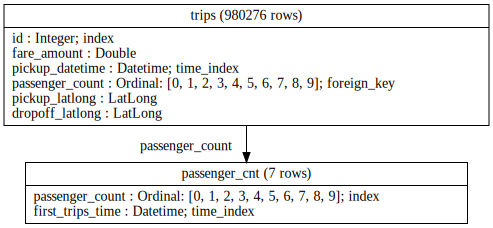

In [33]:
es.plot()

# Pipeline

In [36]:
from utils import Timer
from IPython.display import display

path = "../data/"
TRAIN_PATH = f'{path}/train.csv'
TEST_PATH = f'{path}/test.csv'

cols = [
    'fare_amount', 'pickup_datetime','pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude', 'passenger_count'
]
with Timer("Load test"):
    test = pd.read_csv(TEST_PATH)
    
#sampled_line = 10000000
with Timer(f"Load train full"):
    train = pd.read_csv(TRAIN_PATH, usecols=cols)

print("Raw data")
display(train)

with Timer("Data Wrangling for train"):
    train = clean_df(train)
    
#======= start to use feature tools to enrich =========#
    
with Timer("enrich feature for train"):
    print(f"\n*** before enrich ***")
    print(train.dtypes)
    
    train, es, features = modelling_features(train)
    
    print(f"\n*** after enrich ***")
    print(train.dtypes)
     
print("Before Training")
display(train)


Load test took 0.02510185306891799 sec
Load train full took 59.212941226083785 sec
Raw data


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5000,2009-06-15 17:26:21 UTC,-73.8443,40.7213,-73.8416,40.7123,1
1,16.9000,2010-01-05 16:52:16 UTC,-74.0160,40.7113,-73.9793,40.7820,1
2,5.7000,2011-08-18 00:35:00 UTC,-73.9827,40.7613,-73.9912,40.7506,2
3,7.7000,2012-04-21 04:30:42 UTC,-73.9871,40.7331,-73.9916,40.7581,1
4,5.3000,2010-03-09 07:51:00 UTC,-73.9681,40.7680,-73.9567,40.7838,1
...,...,...,...,...,...,...,...
55423851,14.0000,2014-03-15 03:28:00 UTC,-74.0053,40.7400,-73.9633,40.7626,1
55423852,4.2000,2009-03-24 20:46:20 UTC,-73.9578,40.7655,-73.9516,40.7740,1
55423853,14.1000,2011-04-02 22:04:24 UTC,-73.9705,40.7523,-73.9605,40.7973,1
55423854,28.9000,2011-10-26 05:57:51 UTC,-73.9809,40.7646,-73.8706,40.7740,1


Data Wrangling for train took 8.65574132092297 sec

*** before enrich ***
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object
fare_amount        float64
pickup_datetime     object
passenger_count      int64
pickup_latlong      object
dropoff_latlong     object
dtype: object
Built 14 features
Elapsed: 29:28 | Progress: 100%|██████████

*** after enrich ***
fare_amount                                                  float64
passenger_count                                             category
GEOBOX(dropoff_latlong, (40.62, -73.85), (40.7, -73.75))        bool
GEOBOX(pickup_latlong, (40.62, -73.85), (40.7, -73.75))         bool
GEOBOX(dropoff_latlong, (40.7, -73.97), (40.77, -73.9))         bool
GEOBOX(pickup_latlong, (40.7, -73.97), (40.77, -73.9))          bool
BEARING(dropoff_latlong, pickup_latlong)                     fl

,fare_amount,passenger_count,"GEOBOX(dropoff_latlong, (40.62, -73.85), (40.7, -73.75))","GEOBOX(pickup_latlong, (40.62, -73.85), (40.7, -73.75))","GEOBOX(dropoff_latlong, (40.7, -73.97), (40.77, -73.9))","GEOBOX(pickup_latlong, (40.7, -73.97), (40.77, -73.9))","BEARING(dropoff_latlong, pickup_latlong)","CITYBLOCK(dropoff_latlong, pickup_latlong)",IS_NIGHT_HOUR(pickup_datetime),IS_NOON_HOUR(pickup_datetime),IS_RUSH_HOUR(pickup_datetime),passenger_cnt.IS_NIGHT_HOUR(first_trips_time),passenger_cnt.IS_NOON_HOUR(first_trips_time),passenger_cnt.IS_RUSH_HOUR(first_trips_time)
id,,,,,,,,,,,,,,
43310508,30.2000,1,False,True,False,False,102.8172,31.3826,False,False,False,False,False,False
862908,15.0000,1,False,False,False,False,35.9675,10.2222,False,False,False,False,False,False
13073257,4.2000,1,False,False,False,False,-139.9329,0.6290,False,False,False,False,False,False
647957,5.8000,2,False,False,False,False,11.8035,2.5514,False,False,False,False,False,False
12655086,14.6000,1,False,False,True,False,-118.1861,10.2297,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40210315,24.5000,2,False,False,False,False,-15.5490,15.3465,True,False,False,False,False,False
13957545,6.0000,2,False,False,False,False,38.2798,2.8428,True,False,False,False,False,False
48940597,33.5000,1,False,False,False,False,-45.3376,23.6126,True,False,False,False,False,False


In [37]:
train.to_parquet("featuretools_process_nyc_taxi.parquet")

In [7]:
train

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,dayofyear,weekday,time,distance,direction
0,4.5000,-73.8443,40.7213,-73.8416,40.7123,1,2009,166,0,1022,1029.6007,167.1927
1,16.9000,-74.0160,40.7113,-73.9793,40.7820,1,2010,5,1,965,8443.4414,21.5739
2,5.7000,-73.9827,40.7613,-73.9912,40.7506,2,2011,230,3,3,1389.1322,-148.8690
3,7.7000,-73.9871,40.7331,-73.9916,40.7581,1,2012,112,5,243,2795.7897,-7.7015
4,5.3000,-73.9681,40.7680,-73.9567,40.7838,1,2010,68,1,425,1998.3378,28.8962
...,...,...,...,...,...,...,...,...,...,...,...,...
55423851,14.0000,-74.0053,40.7400,-73.9633,40.7626,1,2014,74,5,182,4339.8703,54.7851
55423852,4.2000,-73.9578,40.7655,-73.9516,40.7740,1,2009,83,1,1204,1070.1565,28.9918
55423853,14.1000,-73.9705,40.7523,-73.9605,40.7973,1,2011,92,5,1320,5069.4491,9.5518
55423854,28.9000,-73.9809,40.7646,-73.8706,40.7740,1,2011,299,2,305,9369.5665,83.6125


# EvalML Train

In [ ]:
def get_split_sets(train):
    x = train.drop(columns=['fare_amount'])
    y = train['fare_amount'].values
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=123)
    return x_train, x_val, y_train, y_val

with Timer("split train and val"):
    x_train, x_val, y_train, y_val = get_split_sets(train)
    
# looking for right ml pipeline
import evalml
from evalml import AutoMLSearch

automl = AutoMLSearch(X_train=x_train,
                      y_train=y_train,
                      X_holdout=X_val,
                      y_holdout=y_val,
                      problem_type="regression",
                      objective="root mean squared error",
                      verbose=True,)
automl.search()

best_pipeline = automl.best_pipeline
with Timer("train"):
    best_pipeline.fit(x_train, y_train)
    
best_pipeline.score(X_val, y_val, objectives=["root mean squared error"])

# LGBM Train

In [9]:
def get_split_sets(train):
    x = train.drop(columns=['fare_amount'])
    y = train['fare_amount'].values
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)
    return x_train, x_val, y_train, y_val

with Timer("split train and val"):
    x_train, x_val, y_train, y_val = get_split_sets(train)

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':1000,
        'num_boost_round': 10000,
        'early_stopping_rounds': 50
    }


lgbm_train = lgbm.Dataset(x_train, y_train, silent=False, categorical_feature=['passenger_count','year','time','dayofyear','weekday'])
lgbm_val = lgbm.Dataset(x_val, y_val, silent=False, categorical_feature=['passenger_count','year','time','dayofyear','weekday'])

with Timer("train"):
    model = lgbm.train(params=params, train_set=lgbm_train, valid_sets=lgbm_val, verbose_eval=100)
    
with Timer("predict"):
    pred = model.predict(x_val, num_iteration=model.best_iteration)
    
with Timer("calculate rmse"):
    rmse = np.sqrt(mean_squared_error(y_val, pred))

print('LightGBM RMSE', rmse)

split train and val took 22.421847986988723 sec
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.834323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30533
[LightGBM] [Info] Number of data points in the train set: 49881470, number of used features: 11
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 11.345439
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 4.63246
Early stopping, best iteration is:

In [12]:
with Timer("split train and val"):
    x_train, x_val, y_train, y_val = get_split_sets(train)

lgbm_params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'reg_sqrt': True,
    'learning_rate': 0.03,
    'num_leaves': 1200,
    'max_depth': -1,
    'max_bin': 5000,
    'num_rounds': 1200,
    'early_stopping_round': 50,
    'metric': 'rmse'
}

lgbm_train = lgbm.Dataset(x_train, y_train, silent=False)
lgbm_val = lgbm.Dataset(x_val, y_val, silent=False)

with Timer("train"):
    model = lgbm.train(params=lgbm_params, train_set=lgbm_train, valid_sets=lgbm_val, verbose_eval=100)
    
with Timer("predict"):
    pred = model.predict(x_val, num_iteration=model.best_iteration)
    
with Timer("calculate rmse"):
    rmse = np.sqrt(mean_squared_error(y_val, pred))

print('LightGBM RMSE', rmse)

split train and val took 3.7570005068555474 sec
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30536
[LightGBM] [Info] Number of data points in the train set: 9000000, number of used features: 12
[LightGBM] [Info] Start training from score 3.177760
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 4.25898
[200]	valid_0's rmse: 4.12228
[300]	valid_0's rmse: 4.08928
[400]	valid_0's rmse: 4.0765
[500]	valid_0's rmse: 4.07053
[600]	valid_0's rmse: 4.06616
[700]	valid_0's rmse: 4.06431
[800]	valid_0's rmse: 4.06246
[900]	valid_0's rmse: 4.06072
[1000]	valid_0's rmse: 4.05996
[1100]	valid_0's rmse: 4.05938
Early stopping, best iteration is:
[1107]	valid_0's rmse: 4.05933
train took 803.9622147129849 sec
predict took 4.348827651701868 sec
calculate rmse

# EDA

In [ ]:
def exploration_features(df):
    """adds features for use in the EDA section"""
    df = shared_features(df)
    df = (
        df
        .assign(
            hour=df.pickup_datetime.dt.hour,
            close_to_airport='No',
            fare_per_km=df.fare_amount*1000/df.distance,
            direction_bucket = pd.cut(df.direction, np.linspace(-180, 180, 37)),

            #small location buckets
            pickup_long_bucket=pd.cut(df.pickup_longitude, bins=2550, labels=False),
            pickup_lat_bucket=pd.cut(df.pickup_latitude, bins=2200, labels=False),
            dropoff_long_bucket=pd.cut(df.dropoff_longitude, bins=2550, labels=False),
            dropoff_lat_bucket=pd.cut(df.dropoff_latitude, bins=2200, labels=False),


            #large location buckets
            pickup_long_bucket_big=pd.cut(df.pickup_longitude, bins=255, labels=False),
            pickup_lat_bucket_big=pd.cut(df.pickup_latitude, bins=220, labels=False),
            dropoff_long_bucket_big=pd.cut(df.dropoff_longitude, bins=255, labels=False),
            dropoff_lat_bucket_big=pd.cut(df.dropoff_latitude, bins=220, labels=False)
        )
        .drop(columns='pickup_datetime')
        .query("0 < distance")
    )

    df.loc[((df['pickup_dist_jfk']<1500) | (df['dropoff_dist_jfk']<1500)), 'close_to_airport'] = 'JFK'
    df.loc[((df['pickup_dist_lga']<1500) | (df['dropoff_dist_lga']<1500)), 'close_to_airport'] = 'LaGuardia'
    df.loc[((df['pickup_dist_nla']<1500) | (df['dropoff_dist_nla']<1500)), 'close_to_airport'] = 'Newark'  
    return df

